# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk

In [349]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [350]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 2]
print("Number of dialogues longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues longer than 2 turns in subreddit:  487


# TODO: CLEAN OUT CONVERSATIONS OF ANY LENGTH WITH ONLY A SPEAKER (e.g. conversation id 25)

In [351]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Measuring the level of engagement

### Does the speaker respond back when the listener gives a response?

In [352]:
def extract_responses(conversation):
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses)
    num_listener_responses = len(listener_responses)
    
    return speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [353]:
def calculate_engagement(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses, conversation):
    # SADECE FARKLARINI DEGIL INDIVIDUALLY SAYILARINI DA DIKKATE ALABILIRSIN 
    diff = calculate_turn_diff(num_speaker_responses, num_listener_responses)
    num_turns = len(conversation)

    engagement = ""
    
    if num_turns == 2:
        engagement = "low engagement"
        
    elif num_turns == 3:
        if num_speaker_responses == 2 and is_interleaved_conversation(speaker_responses, listener_responses) == True : 
            engagement = "moderate engagement" 
        else:
            engagement = "low engagement"
            
    elif num_turns == 4:
        if diff == 0:
            engagement = "high engagement" 
        elif diff == 3: # (only if the 2nd turn is listener, add more if statements)
            engagement = "moderate engagement"
        elif diff == (1/3):
            engagement = "low engagement"
            
    elif num_turns > 4: # 
        if diff >= 0.7 and diff <= 1.35:
            engagement = "high engagement"
        elif diff <= 0.5 or diff >= 1.5: # separate all conditions
            engagement = "low engagement"
        else:
            engagement = "moderate engagement"
        
    return round_sig(diff), engagement

In [354]:
# maybe remove this if you are not going to add anything else to the function
def calculate_turn_diff(num_speaker_responses, num_listener_responses):
    return num_speaker_responses - num_listener_responses

In [355]:
#def calculate_speaker_token_length():
    

In [ ]:
#def merge_consecutive_speaker_responses():

In [397]:
# TOASK: SHOULD I CHECK THIS FOR ANY CONVERSATION LENGTH OR JUST 3 OR 4? --> ACTUALLY, YOU NEED TO MERGE THE SPEAKER TURNS ONE AFTER THE OTHER AND THENNN CHECK THIS FUNCTION
def is_interleaved_conversation(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses):
    diff = calculate_turn_diff(num_speaker_responses, num_listener_responses)
    
    if diff == 1 or diff == 0:
        for i in range(0, num_speaker_responses - 1):
            if listener_responses['dialog_turn'].iloc[i] == (speaker_responses['dialog_turn'].iloc[i] + 1):
                continue
            else:
                return False
        return True
    return False

### Does the listener ask any informative questions or give any suggestions? 

Unfortunately, the emotion predictions are very inaccurate. Normally, we could have given bonus points to questioning and/or suggesting listener responses. 

## Measuring the level of satisfaction

### Shift of sentiment in speaker responses (sentiment trend)

In [357]:
def plot_emotion_sentiment(speaker_responses):   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [358]:
def calculate_satisfaction(speaker_responses, conversation):
    satisfaction = ""

    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]
    
    # If either the last speaker text is tagged with grateful & positive 
    # or if the last speaker text contains lexical details that express gratitude, add a bonus point to satisfaction.
    grateful_bonus = 0
    if check_grateful_positive()==True or check_lexical_details()==True:
        grateful_bonus = 0.4
        slope += grateful_bonus
        
    if len(conversation) == 2:
        satisfaction = "none"
    else:
        if slope >= 0.8: 
            satisfaction = "positive satisfaction"
        elif slope >= 0.4:
            satisfaction = "moderate satisfaction"
        elif slope < 0.4 and slope >= 0:
            satisfaction = "neutral satisfaction"
        elif slope < 0:
            satisfaction = "negative satisfaction"
            
    return round_sig(slope), satisfaction, grateful_bonus

### Check if the last speaker turn has grateful emotion and has positive sentiment

In [359]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction():
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [360]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment():
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [361]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def check_grateful_positive():
    _, final_sentiment = get_sentiment()
    _, final_emotion = get_emotion_prediction()
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

### Check if the last speaker turn contains lexical details that express gratitude, e.g. "Thank you" or "It means a lot"

In [362]:
def check_lexical_details():
    # TO ASK: I couldn't find a gratitude lexicon. Will I create one myself or is there one that I don't know of? e.g. appreciate --> manual inspection & research
    
    tokens = nltk.word_tokenize(speaker_responses["text"].iloc[-1].lower())
    
    if "thank" in tokens: # if we get a lexicon of gratitude I can check if any of those words are in tokens (can also use ngrams)
        return True
        
    return False

## Final classification

In [363]:
def classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation):
    return str(calculate_engagement(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses, conversation)[1] + ", " + calculate_satisfaction(speaker_responses, conversation)[1])

## Testing the measures with examples

In [370]:
def test_examples(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)
    plot_emotion_sentiment(speaker_responses)
    print("Conversation length: ", len(conversation))
    print("Speaker-listener turn difference: ", calculate_engagement(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses, conversation)[0], " --> ", calculate_engagement(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses, conversation)[1])
    print("Sentiment shift: ", calculate_satisfaction(speaker_responses, conversation)[0], " with grateful bonus: ", calculate_satisfaction(speaker_responses, conversation)[2], " --> ", calculate_satisfaction(speaker_responses, conversation)[1])
    print("Classification summary: ", classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation))
    print()

In [377]:
df[df["conversation_id"] == 37]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
85,37,MentalHealthSupport,"As a minor, what can I not tell my therapist without my mom finding out?",slacktherin,1,"If my mom was aware of certain things, I'd be kicked out, hence why I ask.",0.2732,positive,joyful
86,37,MentalHealthSupport,"As a minor, what can I not tell my therapist without my mom finding out?",Leena52,2,It may depend upon the State regulations for mental health professional therapists where you live. In Texas the parent has access to all as does the pay or (insurance provider). That is unless the therapist provides you with proof otherwise. I would ask the therapists.,-0.1027,negative,faithful
87,37,MentalHealthSupport,"As a minor, what can I not tell my therapist without my mom finding out?",slacktherin,3,"Shit, okay",-0.4019,negative,sentimental


Conversation length:  3


TypeError: is_interleaved_conversation() missing 2 required positional arguments: 'num_speaker_responses' and 'num_listener_responses'

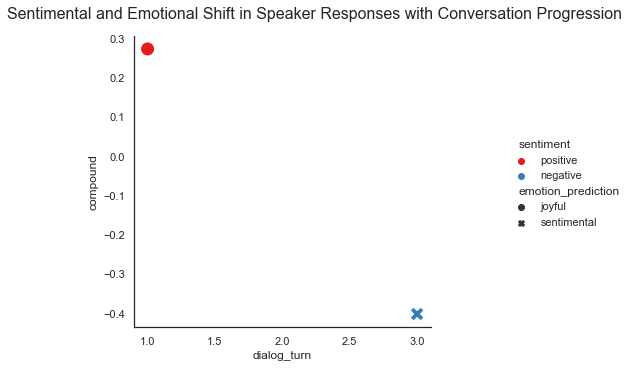

In [376]:
test_examples(37)

In [395]:
conversation = df[df["conversation_id"] == 56]
speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)
is_interleaved_conversation(speaker_responses, listener_responses, num_speaker_responses, num_listener_responses)

True

In [396]:
conversation

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
125,56,MentalHealthSupport,histrionic personality disorder,anuspain420,1,"haven't seen any posts about it on here, wondering here if anyone else has it? ;^^",0.0000,neutral,sentimental
126,56,MentalHealthSupport,histrionic personality disorder,berry_cherry,2,I've never met anyone who has been diagnosed with HPD actually. Even online I don't see people talk about it very much. I have definitely met people who fit the symptoms (in my mind) but even all the treatment I've been in I've never met someone who admitted to be dx'd with HPD. Do you have it? What is it like? What are your symptoms? I am very interested in it and I actually kind of suspect my sister has it or NPD.,0.8290,positive,lonely
127,56,MentalHealthSupport,histrionic personality disorder,anuspain420,3,"Not professionally diagnosed, so no. But I do assume I have it seeing I fit the criteria for it. It's pretty awful considering you have to have the spotlight on you all the time, and then people are mad at you because you don't understand that they can't have attention from others.",-0.1901,negative,embarrassed


### High engagement, positive satisfaction

### High engagement, negative satisfaction

### Moderate engagement, moderate satisfaction

### Low engagement, neutral satisfaction

## Emotion prediction is not accurate at all...

In [367]:
#conversation_bad_emotion_prediction_example = df[df["conversation_id"] == 1754]
#conversation_bad_emotion_prediction_example

When we check the emotion predictions, we see that most of them are very inaccurate. The sentiment tags are more accurate, but sometimes they fail too.

In [368]:
#df[df["emotion_prediction"]=="questioning"]

The questioning tags are not accurate either. Only one of the statements that are tagged with the questioning tag are actually questioning.

In [369]:
#df[df["emotion_prediction"]=="suggesting"]

There are no turns tagged as suggesting.

## TODO: Improve these scoring functions

Satisfaction: 
- Take off points if speaker got offended from listener's response
- Find a lexicon of gratitude tokens

Engagement:
- Number of tokens speaker used to respond back (excluding the first turn), i.e. when the speaker responds back, is it a shorter/longer response elaborating the situation
- Check if the turns are interleaved (i.e. if there is interaction)
- Change ratio to difference

Examples:
- A few examples showing low/moderate/high engagement/satisfaction
